# Demonstrate full circle: prediction of components, inversion, point source fitting

In [1]:
%matplotlib inline

import os
import sys
import copy

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy.time import Time
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.operations import create_visibility, sum_visibility
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration

from matplotlib import pyplot as plt

from arl.skymodel.operations import create_skycomponent, find_skycomponents, fit_skycomponent, find_nearest_component
from arl.image.operations import show_image, export_image_to_fits, reproject_image
from arl.image.iterators import raster_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import invert_2d, create_image_from_visibility, \
    weight_visibility, predict_skycomponent_visibility, invert_timeslice, invert_by_image_partitions

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)

doplot = True

### Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

### We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.arange(- numpy.pi / 4.0, + numpy.pi * 1.001 / 4.0, numpy.pi / 16.0)
frequency = numpy.array([1e8])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=0.0 * u.deg, frame='icrs', equinox=2000.0)

In [4]:
params = {'npixel': 512,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8}

vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, params=params)

### Fill in with point sources

In [5]:
params = {'npixel': 512,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8}

flux = numpy.array([[100.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, params=params)
centre_ra  = model.wcs.wcs.crpix[0]-1
centre_dec = model.wcs.wcs.crpix[1]-1
spacing_pixels = params['npixel'] // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * params['cellsize'] * spacing_pixels / numpy.pi
centers = -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in centers:
    for ix in centers:
        pra, pdec = round(centre_ra + ix * spacing_pixels),\
                    round(centre_dec + iy * spacing_pixels)
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
        original_comps.append(comp)
        predict_skycomponent_visibility(vt, comp)

### Check the visibility summed at the phase center

In [6]:
print("Flux at phase centre %s" % sum_visibility(vt, phasecentre, params=None)[0])

Flux at phase centre [[-2.65066753]]


In [7]:
### Make image using 2d transform

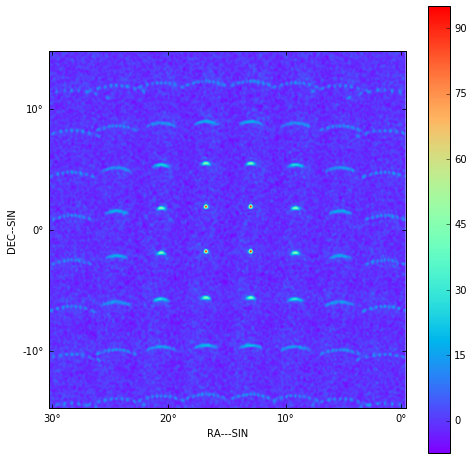

In [8]:
params = {'npixel': 512,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'padding':2,
          'oversampling':32}

targetimage = create_image_from_visibility(vt, params=params)
targetimage = invert_2d(vt, targetimage, params=params)
psfimage = create_image_from_visibility(vt, params=params)
psfimage = invert_2d(vt, psfimage, dopsf=True, params=params)
psfmax = psfimage.data.max()

targetimage.data /= psfmax
psfimage.data /= psfmax

show_image(targetimage)
plt.show()

### Make the image using timeslices

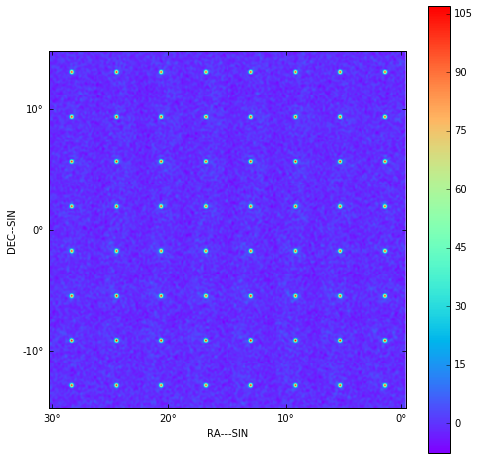

In [9]:
params = {'npixel': 512,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'timeslice': 30.0,
          'padding':2,
          'oversampling':32,
          'image_partitions':8}

targetimage = create_image_from_visibility(vt, params=params)
targetimage = invert_by_image_partitions(vt, targetimage, params=params)
psfimage = create_image_from_visibility(vt, params=params)
psfimage = invert_by_image_partitions(vt, psfimage, dopsf=True, params=params)
psfmax = psfimage.data.max()

targetimage.data /= psfmax
psfimage.data /= psfmax

show_image(targetimage)
plt.show()

### Now we find the sources

In [10]:
comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5, params=None)

<SkyCoord (ICRS): (ra, dec) in deg
    (24.45312706, -12.94725129)> [[ 100.97299654]]
<SkyCoord (ICRS): (ra, dec) in deg
    (1.71284459, -12.94813339)> [[ 101.54118057]]
<SkyCoord (ICRS): (ra, dec) in deg
    (28.28812456, -12.94129232)> [[ 102.49859401]]
<SkyCoord (ICRS): (ra, dec) in deg
    (20.6534463, -12.94248037)> [[ 96.76528032]]
<SkyCoord (ICRS): (ra, dec) in deg
    (16.88112762, -12.94087419)> [[ 100.02838439]]
<SkyCoord (ICRS): (ra, dec) in deg
    (13.12212487, -12.94277589)> [[ 101.84829727]]
<SkyCoord (ICRS): (ra, dec) in deg
    (9.34895819, -12.94363594)> [[ 99.75265933]]
<SkyCoord (ICRS): (ra, dec) in deg
    (5.5505112, -12.94153252)> [[ 101.89714435]]
<SkyCoord (ICRS): (ra, dec) in deg
    (28.11708136, -9.21029039)> [[ 105.46776797]]
<SkyCoord (ICRS): (ra, dec) in deg
    (24.32590027, -9.20803324)> [[ 105.26769303]]
<SkyCoord (ICRS): (ra, dec) in deg
    (20.5818003, -9.20908989)> [[ 105.01885466]]
<SkyCoord (ICRS): (ra, dec) in deg
    (16.8602306, -9.20903619)>

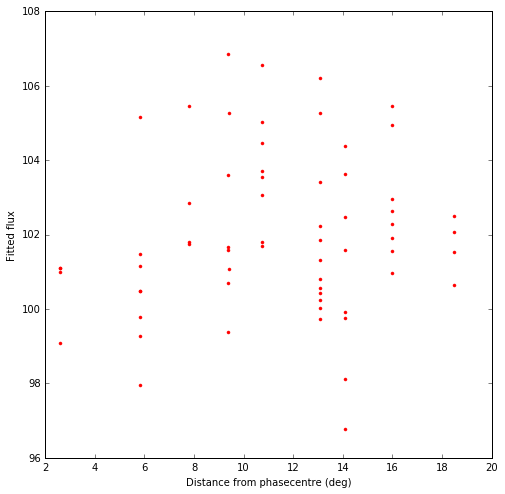

In [11]:
plt.clf()
for comp in comps:
    distance = comp.direction.separation(phasecentre)
    plt.plot(distance.deg, comp.flux[0,0], '.', color='r')  
plt.xlabel('Distance from phasecentre (deg)')
plt.ylabel('Fitted flux')
plt.show()

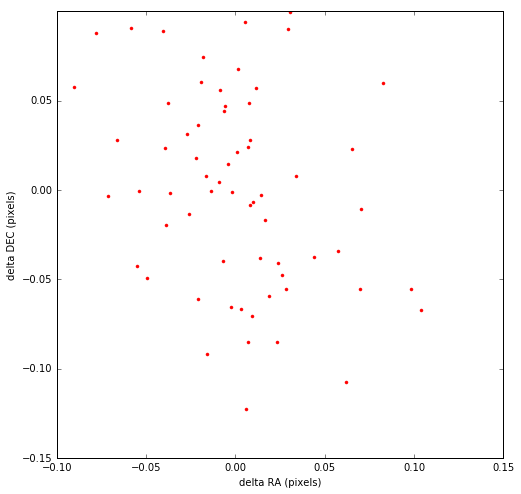

In [12]:
plt.clf()
cellsize=180.0*params['cellsize']/numpy.pi
for i in range(len(comps)):
    ocomp = find_nearest_component(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cellsize, 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cellsize, '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.show()

In [13]:
print(targetimage.wcs)

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 15.0  0.0  1.0  100000000.0  
CRPIX : 256.0  256.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.057295779513082318  0.057295779513082318  1.0  50000000.0  
NAXIS    : 0 0
